In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Train, Test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [3]:
pd.set_option('display.max_columns', None)

In [8]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pkl', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pkl', 'rb') as file:
    y_scaler = pickle.load(file)

In [10]:
df = pd.read_csv("../bin/data_process.csv")

In [12]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['precio_contado'], axis=1)  
y = df['precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [14]:
modelos = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "adaboost": AdaBoostRegressor(),
    "kneighbors": KNeighborsRegressor(),
    "linear_regressor": LinearRegression(),
    "svr": SVR()
}

In [16]:
%%time
resultados = []

for regresor, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    
    y_pred = modelo.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
    y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
    
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
    resultados.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by = "R2_score", ascending = False)

CPU times: total: 2.53 s
Wall time: 4.24 s


In [17]:
df_resultados

,Nombre_modelo,MAE,MSE,R2_score
0,random_forest,2569.580617,1.722446e+07,0.898160
2,gradient_boosting,2960.388414,1.932306e+07,0.885752
6,svr,2974.007239,2.167424e+07,0.871851
4,kneighbors,3051.188804,2.419049e+07,0.856973
1,decision_tree,3257.199039,2.861315e+07,0.830824
5,linear_regressor,3974.841613,3.355142e+07,0.801627
3,adaboost,5527.295967,4.633516e+07,0.726043


modelo: (0.49627891263608387) 
potencia_cv: (0.1643901704105806) 
antiguedad_coche: (0.14740807120737762) 
log_kilometraje: (0.11723728221616964) 
tipo_cambio: (0.03285626733470447) 
marca: (0.02368773642117816) 
distintivo_ambiental_ECO: (0.005011173655009812) 
distintivo_ambiental_C: (0.003845374113147197) 
combustible_Gasolina: (0.0036715232959582357) 
combustible_Híbrido Enchufable: (0.0030880496265484414) 
combustible_Eléctrico: (0.00233196223540597) 
distintivo_ambiental_B: (0.0001570791545773313) 
combustible_Gasolina/gas: (3.2542568243268494e-05) 
combustible_Gas: (3.85512501540047e-06) 


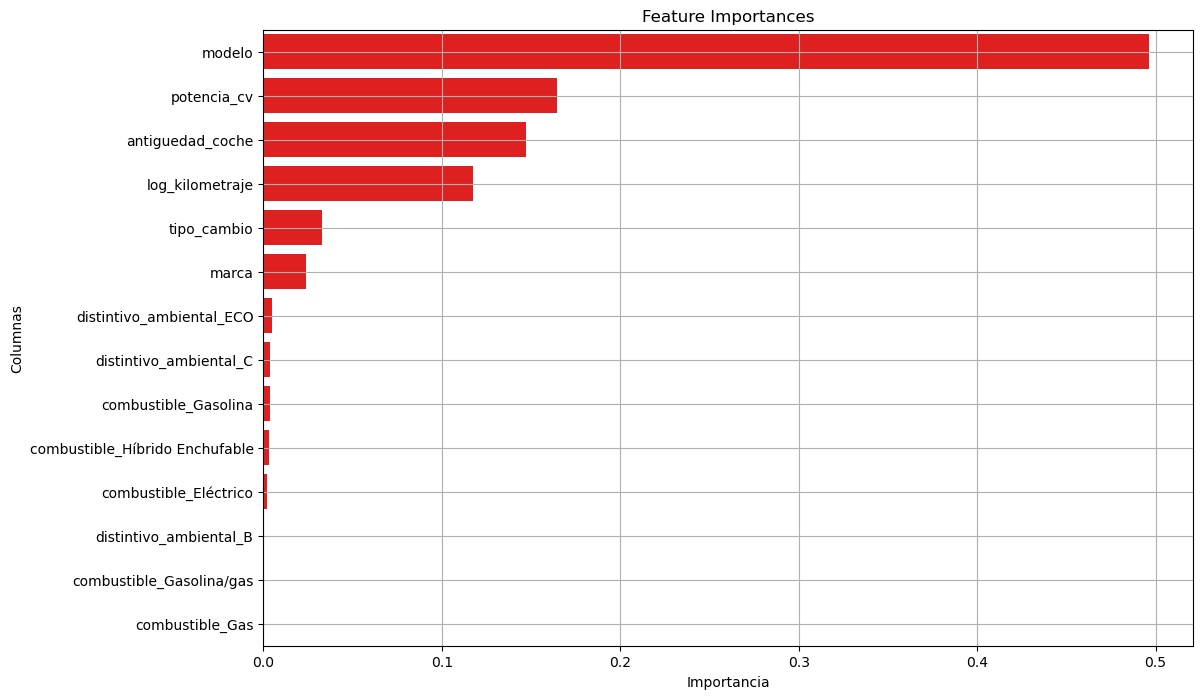

CPU times: total: 4.59 s
Wall time: 5.61 s


In [9]:
%%time
# Modelo de RandomForest para obtener Feature Importance
model = RandomForestRegressor(n_estimators = 250,
                               random_state = 33)
# Entrenamos el modelo
model.fit(x, y)

# Calculamos Feature Importance
importances = model.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [10]:
%%time

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)}



params = {"n_estimators"           : [100, 150],
          "criterion"              : ["squared_error", "absolute_error"], 
          "max_depth"              : [10, 15],
          "max_leaf_nodes"         : [90, 120],
          "min_samples_split"      : [2, 10],
          "random_state"           : [33]} 

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "R2",
                           n_jobs     = -1        ,
                           verbose    = 3)

model_result = grid_solver.fit(x, y)

print(model_result.cv_results_["mean_test_MAE"].mean())
print(model_result.cv_results_["mean_test_MSE"].mean())
print(model_result.cv_results_["mean_test_R2"].mean())

print("*" * 100)

print(model_result.best_score_)
print(model_result.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
-0.24451019281208303
-0.12521736344387144
0.8728924591304394
****************************************************************************************************
0.8807661482874696
{'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 33}
CPU times: total: 1.81 s
Wall time: 12min 49s


In [22]:
best_params = {'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 33}

In [24]:
mejor_modelo = RandomForestRegressor(**best_params)

mejor_modelo.fit(x, y)

RandomForestRegressor(max_depth=15, max_leaf_nodes=120, min_samples_split=10,
                      n_estimators=150, random_state=33)

In [28]:
resultados_mejor_modelo = []
y_pred = mejor_modelo.predict(x_test)
y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()

regresor = 'Random forest'
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
resultados_mejor_modelo.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
resultados_mejor_modelo = pd.DataFrame(resultados_mejor_modelo)
resultados_mejor_modelo

,Nombre_modelo,MAE,MSE,R2_score
0,Random forest,2553.809549,1.242557e+07,0.926534


modelo: (0.523562316039206) 
potencia_cv: (0.1667298230330495) 
antiguedad_coche: (0.14301535261620607) 
log_kilometraje: (0.10374153338865395) 
tipo_cambio: (0.03434441465806087) 
marca: (0.016412020678645247) 
distintivo_ambiental_ECO: (0.003830405898371591) 
distintivo_ambiental_C: (0.002855458284473447) 
combustible_Híbrido Enchufable: (0.0021176502150061787) 
combustible_Gasolina: (0.0017263282251520264) 
combustible_Eléctrico: (0.0016345505225462639) 
distintivo_ambiental_B: (3.0146440628817066e-05) 
combustible_Gas: (0.0) 
combustible_Gasolina/gas: (0.0) 


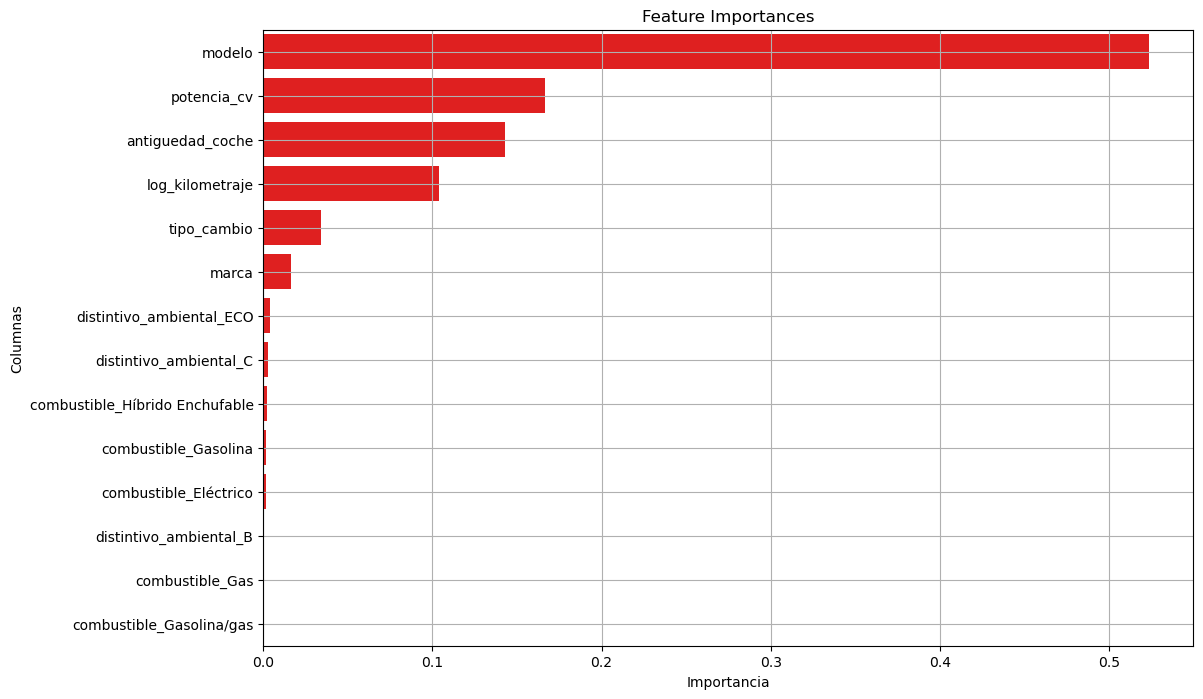

CPU times: total: 219 ms
Wall time: 379 ms


In [44]:
%%time
# Calculamos Feature Importance
importances = mejor_modelo.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()

plt.savefig('../bin/imagenes/feature_importance.png')

plt.show()

In [46]:
#Crear una carpeta para guardar el modelo

os.makedirs("modelo", exist_ok=True)

with open("modelo/mejor_modelo.pkl", "bw") as file:
    pickle.dump(mejor_modelo, file)